In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))
print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(3486, 35)
(3486, 3)


In [6]:
X_motion_CoM[0, :]

array([0.1, 0.0, 0.0, 0.24250255428344528, 0.12329102023941216,
       -0.35588358402421133, 0.2650011226270009, -0.12922865183828147,
       -0.33840883005275446, -0.25402972104181887, 0.13412602503258667,
       -0.34100059522893345, -0.276221429648406, -0.12968662582785478,
       -0.3563335160552942, 29.24401455162357, 0.22324592575715008,
       0.3831408956999503, 0.001394327867534934, 0.0022510799832809692,
       0.003981016726044183, 0.9999885699319436, 0.07074625704318646,
       -0.0009981940584712719, 0.01794437084779908, -0.011051429108737123,
       -0.01974010197847388, 0.01389025871255961, nan, nan, 0.1, 0.0, 0.0,
       True, False], dtype=object)

# Multivariate Linear Regression (Foot prediction)

In [7]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [8]:
# Entries where FL foot is swinging
idx_fl_rr_swinging = np.where(X_motion_CoM[:, -2] == 1)[0]
X_motion_CoM_FL_RR = X_motion_CoM[idx_fl_rr_swinging]
Y_motion_CoM_FL_RR = Y_motion_CoM[idx_fl_rr_swinging]

In [9]:
idx_fl_rr_swinging.shape

(1740,)

## Predict CoM -> x

### Linear Regression

In [10]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, -5:-2], # Current motion command
               X_motion_CoM_FL_RR[:, 3:5], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 6:8], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_x = LinearRegression()

# Fit the model
model_fl_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9736309694256502
RMSE:  0.01262906111494542
The lowest error is:  1.0577668750150204e-05
The highest error is:  0.05042455688769695
The avg. error is:  0.008058364153323375


In [11]:
model_fl_com_x.coef_

array([[ 1.15640461e-01,  2.35210600e+08,  5.00022616e+10,
         1.02041930e-01,  1.75486912e+08, -5.00022616e+10,
        -1.09037831e-02,  2.00220840e-01,  1.03882238e-01,
        -5.54988282e-01,  1.10161625e-01,  3.28755803e-01,
         1.04123121e-01,  1.19731731e-01]])

In [12]:
model_fl_com_x.intercept_

array([-0.09113394])

In [13]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0,0.2399, 0.134, 0.2399, -0.134, -0.2399, 0.134, -0.2399, -0.134]])
input_ @ model_fl_com_x.coef_.T + model_fl_com_x.intercept_

array([[0.01917612]])

Text(0, 0.5, 'Predictions')

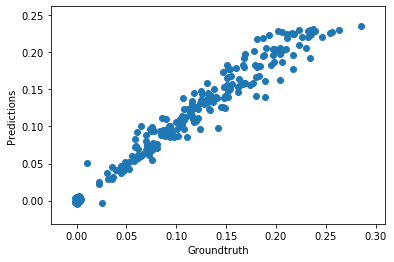

In [14]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [15]:
#%store model_fl_com_x

In [16]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [17]:
# Save model
#joblib.dump(model_fl_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [18]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, -5:-2], # Current motion command
               X_motion_CoM_FL_RR[:, 3:5], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 6:8], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_y = LinearRegression()

# Fit the model
model_fl_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.7931426997928676
RMSE:  0.003300594891858179
The lowest error is:  1.0263900875270154e-05
The highest error is:  0.01538000078620766
The avg. error is:  0.0025629172534692396


In [19]:
model_fl_com_y.coef_

array([[ 3.32751373e-03, -1.20269866e+09, -2.55675778e+11,
        -3.04236412e-02, -8.97314465e+08,  2.55675778e+11,
         5.59079275e-02,  1.23547763e-03, -6.34575188e-02,
         8.62759724e-02,  1.51131749e-01,  1.60955861e-01,
        -1.31967738e-01, -1.61060452e-01]])

In [20]:
model_fl_com_y.intercept_

array([-0.0223178])

Text(0, 0.5, 'Predictions')

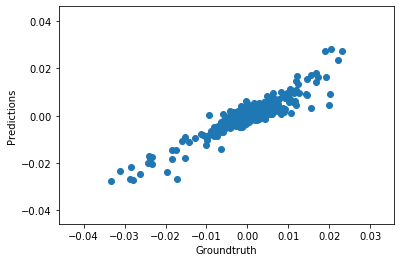

In [21]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [22]:
#%store model_fl_com_y

In [23]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [24]:
# Save model
#joblib.dump(model_fl_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_y.sav")

## Predict CoM -> Yaw

In [25]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, -5:-2], # Current motion command
               X_motion_CoM_FL_RR[:, 3:5], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 6:8], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_theta = LinearRegression()

# Fit the model
model_fl_com_theta.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_theta.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9864481286314759
RMSE:  0.010052949751209298
The lowest error is:  5.893849954124314e-06
The highest error is:  0.06485254958290354
The avg. error is:  0.004910405551318963


In [26]:
model_fl_com_theta.coef_

array([[ 2.75797795e-03, -1.40457516e+09, -2.98591707e+11,
        -6.28590584e-03, -1.04793133e+09,  2.98591707e+11,
         1.93734869e-01, -3.42363261e-01, -5.74413538e-01,
        -4.42491665e-01,  5.73188007e-01,  4.22596335e-01,
        -2.81285569e-01,  3.93991828e-01]])

In [27]:
model_fl_com_theta.intercept_

array([0.15391401])

Text(0, 0.5, 'Predictions')

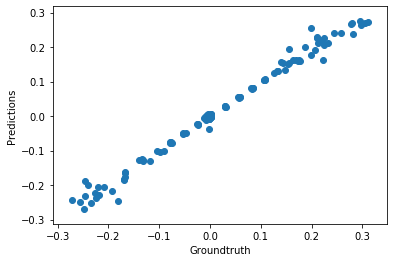

In [28]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")